In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
from nltk.tokenize import word_tokenize
#from numpy import zeros
#from pickle import dump
#from os import chdir

In [2]:
# Loading custom defined functions
#wd = open('wd.cfg').read()
#chdir(wd)
from tokenization import tokenize_sentence_nltk, tokenize_treetagger
from util import read_file, flatten_list_of_list, read_folder#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, postprocess_sentences, get_redundaunt_info
from util import filter_data, filter_senders, filter_recipients, search_patterns
from pos_tagging import run_treetagger_pos_tag_text
from modeling import apply_bigram_trigram_model, run_aff_prop_with_distances, run_kmeans
from nltk.stem import WordNetLemmatizer
from modeling import run_word2vec_model, run_lda_topic_model, build_logistic_regression
from visualizing import visualize_word2vec_model
from util import get_semantic_similarity, get_character_similarity
from lemmatization import lemmatize_treetagger
from util import run_treetagger, join_tokens, parse_date, is_spelled_correctly
from json import load

In [3]:
DetectorFactory.seed = 0

in_file = load(open("in_file.cfg", 'r'))
patterns_file = in_file["patterns_file"]
file_folder = in_file["file_folder"]
label = in_file["label"]
column = in_file["column"]
in_type = in_file["in_type"]
in_file = in_file["in_file"]
if file_folder == "file":
    strings = read_file(in_file, in_type = in_type)
    if in_type == "text":
        strings = tokenize_sentence_nltk(strings)
        strings = DataFrame(strings)[0]
    elif in_type == "html_chat":
        timestamp = strings[2]
        meta_data = strings[1]
        strings = strings[0]
        strings[label] = meta_data["Comment"]
        labels = strings[label]
        strings = strings[col]
    else:
        if label in strings.columns:
            labels = strings[label]
        strings = strings[col]
else:
    strings = read_folder(in_file, in_type = in_type)

patterns = Series([".*" + x + ".*" for x in open(patterns_file, 'r').readlines()])

In [4]:
if in_type == "html_email" or in_type == "enron_email":
    conv = strings["conversation"].apply(tokenize_sentence_nltk)
    strings = strings["meta_data"].apply(Series)
    strings["conversation"] = conv
    try:
        strings["Sent"] = strings["Sent"].apply(parse_date)
    except:
        pass
    try:
        # 1900/01/01 00:00:00 is equivalent to NULL
        strings["Date"] = strings["Date"].apply(parse_date) # This is time consuming function, but it is robust
    except:
        pass


In [5]:
strings.head()

,Cc,ContentTransferEncoding,ContentType,Date,From,MessageID,MimeVersion,Sent,Subject,To,XFileName,XFolder,XFrom,XOrigin,XTo,Xbcc,Xcc,conversation
0,NaN,7bit,text/plain; charset=us-ascii,NaT,heather.dunton@enron.com,<16159836.1075855377439.JavaMail.evans@thyme>,1.0,1900-01-01 00:00:00,RE: West Position,k..allen@enron.com,pallen (Non-Privileged).pst,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox","Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...",Allen-P,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,[Please let me know if you still need Curve Sh...
1,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-07 05:14:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather,., ., ., ., Did you attach the file t..."
2,NaN,NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-05 13:43:00,FW: West Position,"Allen, Phillip K.; Belden, Tim",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/16, 1/30..."
3,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-05 06:41:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather,., ., ., ., This is exactly what we n..."
4,"Driscoll, Michael M",NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-04 15:12:00,West Position,"Belden, Tim; Allen, Phillip K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/18, 1/31..."


In [6]:
if in_type == "html_chat":
    redundant = get_redundaunt_info(strings)
    total_redundant = redundant.sum()
    from re import findall
    unnecessary1 = strings['sender'].apply(lambda x: len(findall("^gg.*", x.lower())) > 0)
    unnecessary2 = strings['participants'].apply(lambda x: sum([len(findall("^gg.*|\;gg.*", y)) for y in x]) > 0)
    unnecessary = unnecessary1 | unnecessary2
    total_unnecessary = unnecessary.sum()
    # Deduplication
    strings = filter_senders(strings)
    strings.head()
    strings = filter_recipients(strings)
    strings.head()
    strings = filter_data(strings)
    strings.head()
    strings1 = strings.drop(['messages'], axis = 1).reset_index(drop = True)
    strings = strings['messages'].reset_index(drop = True)
    strings = strings.apply(lambda x: " ".join(x))


In [7]:
strings.head()

,Cc,ContentTransferEncoding,ContentType,Date,From,MessageID,MimeVersion,Sent,Subject,To,XFileName,XFolder,XFrom,XOrigin,XTo,Xbcc,Xcc,conversation
0,NaN,7bit,text/plain; charset=us-ascii,NaT,heather.dunton@enron.com,<16159836.1075855377439.JavaMail.evans@thyme>,1.0,1900-01-01 00:00:00,RE: West Position,k..allen@enron.com,pallen (Non-Privileged).pst,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox","Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...",Allen-P,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,[Please let me know if you still need Curve Sh...
1,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-07 05:14:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather,., ., ., ., Did you attach the file t..."
2,NaN,NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-05 13:43:00,FW: West Position,"Allen, Phillip K.; Belden, Tim",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/16, 1/30..."
3,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-05 06:41:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather,., ., ., ., This is exactly what we n..."
4,"Driscoll, Michael M",NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-04 15:12:00,West Position,"Belden, Tim; Allen, Phillip K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/18, 1/31..."


In [8]:
try:
    strings = strings["conversation"]
except:
    pass

strings = strings.apply(postprocess_sentences)

In [9]:
# Identifying keyword hits
hits = strings.apply(lambda x: search_patterns(x, patterns))
hits['any'] = hits.apply(sum, axis = 0)
hit_strings = strings[hits['any'] > 0]
# hit_strings = strings[hits]

In [10]:
# Language filter for downstream NLP
languages = strings.apply(detect_language)

# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
# labels = labels[english_only].tolist()

In [11]:
# Processing English sentences:
# 1) Splitting sentences
sentences = strings.apply(tokenize_treetagger)
lengths = sentences.apply(len).tolist()
# new_labels = []
# for i in range(len(lengths)):
#     for j in range(lengths[i]):
#         new_labels.append(labels[i])
# new_labels = Series(new_labels)
# sentences1 = flatten_list_of_list(sentences)

In [12]:
sentences = sentences[sentences.apply(len) > 0]

In [13]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = sentences.apply(lambda x: join_tokens(x))
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

In [17]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
# inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
# labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

In [18]:
sentences1.shape

(77,)

In [19]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [21]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+lemmatize_treetagger(run_treetagger(i.lower())) if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
# labels = labels.tolist() + inc_labels.tolist()

In [22]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "")+"\n")

out_file.close()

In [23]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

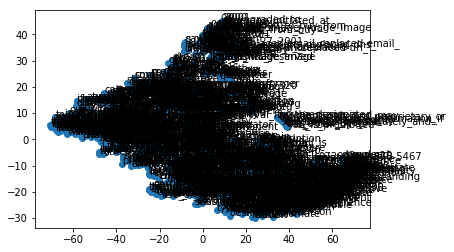

In [24]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

In [25]:
# 9) Setting up the data for building logistic regression model
#df = zeros((len(sentences1), 100))
#for i, words in enumerate(trigrams):
#    for word in words:
#        try:
#            df[i] = df[i] + model[word]
#        except:
#            continue

#while(i<len(sentences1)):
#    i += 1
#
#df = DataFrame(df)
#df[label] = labels

In [26]:
# 10) Building and saving the logistic regression model with L1 penalty
#lr_model = build_logistic_regression(df, label)
#dump(lr_model, open("logistic_model.pkl", 'wb'))

In [27]:
# 11) Topic modeling (Optional)
#lda_model = run_lda_topic_model(text_file = "sample_cleaned.txt")
# Sample topic modeling output - Topic 1
#lda_model.print_topic(1)

In [28]:
sim1 = get_semantic_similarity(model)

In [29]:
vocab = list(model.wv.vocab)

In [30]:
ratio = get_character_similarity(vocab, 'ratio')

In [31]:
partial_ratio = get_character_similarity(vocab, "partial_ratio")

In [32]:
token_sort_ratio = get_character_similarity(vocab, "token_sort_ratio")

In [33]:
token_set_ratio = get_character_similarity(vocab, "token_set_ratio")

In [34]:
sim1 = sim1[ratio.columns]
sim1 = sim1.loc[ratio.columns]

In [35]:
semantic_weight = 0.5
ratio_weight = 0.4
partial_ratio_weight = 0.4
token_sort_ratio_weight = 0.1
sim = semantic_weight*sim1 + (ratio_weight*ratio + partial_ratio_weight*partial_ratio + token_sort_ratio_weight*token_sort_ratio + (1-ratio_weight-partial_ratio_weight-token_sort_ratio_weight)*token_set_ratio)*(1-semantic_weight)
dist = 1 - sim

In [36]:
aff = run_aff_prop_with_distances(dist)

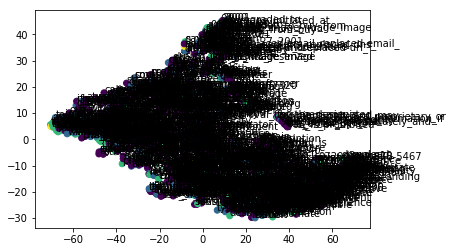

In [37]:
visualize_word2vec_model(model, aff.labels_)

In [38]:
columns = sim.columns
condition = Series(sim.columns).apply(is_spelled_correctly)
sim = sim.loc[columns[~condition]]
sim = sim[columns[condition]]

In [39]:
sim.apply(lambda x: x.sort_values().index[0], axis = 1)

0                         image_image_image_image
0.00                      image_image_image_image
0.030                     image_image_image_image
0.65                      image_image_image_image
00                        image_image_image_image
000                replaced-email_replaced-email_
000000000067320           image_image_image_image
001                       image_image_image_image
00pm                      image_image_image_image
01                        image_image_image_image
02                        image_image_image_image
03                 replaced-email_replaced-email_
04                                            the
05                                            the
06                        image_image_image_image
07                        image_image_image_image
08                                            the
081                       image_image_image_image
09                                            the
096                replaced-email_replaced-email_


In [40]:
df = DataFrame(model.wv[model.wv.vocab])
df.columns = ['c' + str(i) for i in range(df.shape[1])]
km = run_kmeans(model.wv[model.wv.vocab])

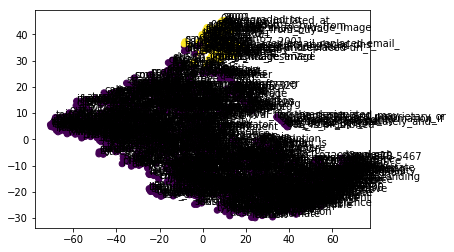

In [41]:
visualize_word2vec_model(model, km.cluster)

In [42]:
lda_model, corpus, dictionary = run_lda_topic_model(text_file = "sample.txt")

In [43]:
lda_model.print_topics(-1)

[(0,
  '0.022*"request" + 0.015*"resource" + 0.015*"this_request" + 0.013*"replaced-url_replaced-url" + 0.011*"replaced-email_replaced-email" + 0.011*"please" + 0.010*"review" + 0.009*"type" + 0.008*"512" + 0.008*"right"'),
 (1,
  '0.021*"draw" + 0.016*"date" + 0.016*"cost" + 0.013*"2" + 0.013*"day" + 0.012*"cash" + 0.011*"total" + 0.010*"prior" + 0.009*"land" + 0.009*"1"'),
 (2,
  '0.015*"please" + 0.012*"information" + 0.010*"account" + 0.010*"your_password" + 0.008*"attach" + 0.008*"heather" + 0.008*"this_email" + 0.008*"file" + 0.008*"replaced-url_replaced-url" + 0.008*"try"'),
 (3,
  '0.021*"psa" + 0.018*"distribution" + 0.017*"share" + 0.015*"balance" + 0.015*"section" + 0.013*"stock" + 0.012*"plan" + 0.011*"account" + 0.009*"deferral" + 0.009*"accelerate"'),
 (4,
  '0.013*"replaced-url_replaced-url" + 0.005*"replaced-email_replaced-email" + 0.004*"zdnet" + 0.004*"scenario" + 0.004*"script" + 0.004*"image" + 0.003*"review" + 0.003*"kirk" + 0.003*"see" + 0.003*"book"'),
 (5,
  '0.

In [44]:
from util import get_word_lda_topics
Series(list(model.wv.vocab.keys())).apply(lambda x: get_word_lda_topics(x))

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
1404    None
1405    None
1406    None
1407    None
1408    None
1409    None
1410    None
1411    None
1412    None
1413    None
1414    None
1415    None
1416    None
1417    None
1418    None
1419    None
1420    None
1421    None
1422    None
1423    None
1424    None
1425    None
1426    None
1427    None
1428    None
1429    None
1430    None
1431    None
1432    None
1433    None
Length: 1434, dtype: object

In [45]:
from visualizing import visualize_lda_topics
visualize_lda_topics(lda_model, corpus, dictionary)


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
69     7.933721        1       1 -0.230989  0.120837
80     7.517181        1       2 -0.013430 -0.110942
30     6.729940        1       3  0.027254  0.086290
7      5.627895        1       4  0.131366  0.178794
95     5.518770        1       5  0.144207  0.039892
34     5.461480        1       6 -0.059199 -0.124877
37     4.948033        1       7 -0.167110  0.089271
84     4.663505        1       8  0.004439 -0.121312
76     3.955984        1       9  0.123518  0.071278
82     3.400690        1      10 -0.057361  0.009512
27     3.353272        1      11  0.121827  0.136578
38     2.881991        1      12 -0.029219 -0.052197
52     2.420221        1      13 -0.142447  0.124144
1      2.084303        1      14  0.067488 -0.048895
33     2.078082        1      15  0.049450 -0.061546
67     1.982914        1      16  0.085779 -0.010312
72     1.968750        1      17 -0.008231 -0.013300
53     1.626044        1      18  0.093723 -0.029818
13     1.569530        1      19  0.079469  0.060568
35     1.569138        1      20  0.055958  0.033175
19     1.498849        1      21  0.061367  0.164363
96     1.474011        1      22  0.003184 -0.098786
68     1.328298        1      23  0.101641  0.132196
40     1.310574        1      24 -0.062779 -0.028229
63     1.275790        1      25 -0.178773  0.150914
41     1.129040        1      26 -0.097744  0.074046
91     1.051760        1      27 -0.003149 -0.031351
50     0.970322        1      28  0.059867  0.034410
94     0.959008        1      29  0.083948  0.020599
73     0.929392        1      30  0.157247  0.075075
...         ...      ...     ...       ...       ...
87     0.008436        1      71 -0.073008  0.083648
6      0.008436        1      72  0.053398  0.023923
88     0.008436        1      73 -0.030704 -0.083027
4      0.008436        1      74  0.006203 -0.040112
3      0.008436        1      75 -0.032008 -0.016664
92     0.008436        1      76 -0.006405 -0.034784
93     0.008436        1      77  0.038947  0.060372
77     0.008436        1      78  0.002618 -0.003556
66     0.008436        1      79 -0.132414  0.076827
47     0.008436        1      80 -0.003814 -0.002980
61     0.008436        1      81  0.042967 -0.012243
51     0.008436        1      82  0.040507  0.033593
39     0.008436        1      83 -0.030888  0.036418
56     0.008436        1      84  0.015247 -0.029577
57     0.008436        1      85 -0.019878 -0.134511
36     0.008436        1      86  0.016616 -0.108337
58     0.008436        1      87 -0.034049 -0.051533
59     0.008436        1      88  0.085273  0.085343
60     0.008436        1      89 -0.017126 -0.029101
31     0.008436        1      90 -0.017126 -0.029101
22     0.008436        1      91  0.000278 -0.047750
62     0.008436        1      92 -0.062776 -0.046313
29     0.008436        1      93  0.006563 -0.007173
28     0.008436        1      94  0.010280 -0.020727
64     0.008436        1      95 -0.023619  0.030759
26     0.008436        1      96  0.020224 -0.025574
25     0.008436        1      97 -0.010271 -0.026355
24     0.008436        1      98  0.039328 -0.055211
23     0.008436        1      99  0.002007 -0.077804
99     0.008436        1     100  0.009516 -0.003543

[100 rows x 5 columns], topic_info=      Category       Freq                           Term      Total  loglift  \
term                                                                           
55     Default  55.000000                           2001  55.000000  30.0000   
302    Default  30.000000        image_image_image_image  30.000000  29.0000   
43     Default  37.000000      replaced-url_replaced-url  37.000000  28.0000   
319    Default  34.000000                          image  34.000000  27.0000   
244    Default  44.000000                         please  44.000000  26.0000   
249    Default  45.000000  replace

In [46]:
sentences1[33:52]

['if_you can read this_email please_click here 20 replaced-dns_replaced-dns_ < csco upgrade downgrade history replaced-dns_replaced-dns_ < 09 image 09_09 image view today s upgrade downgrade coverage_initiated briefing cisco system inc csco date brokerage firm action detail 10 29 2 001 a.g. edwards downgraded_to_buy_from strong_buy 10 15 2001 needha m company downgraded_to_buy_from strong_buy 10 09 2001 j.p. morgan downgraded_to lt buy_from buy 10 04 2001 Unterberg towbin upgrade t o strong_buy_from_buy 10 03 2001 Buckingham research upgraded_to accum ulate from neutral 09 24 2001 Needham company upgraded_to strong_buy from hold 09 20 2001 soundview technology coverage_initiated_at buy 08 24 2001 f van kasper upgraded_to strong_buy_from_buy 08 08 2001 cibc world market upgraded_to buy_from hold 08 08 2001 Needham com pany downgraded_to hold from_buy 07 30_2001 dresdner kleinwort wasser stein downgraded_to reduce from hold 07 23 2001 Warburg dillon reed upgraded_to buy_from hold 05 29 2